In [ ]:
# utilities
import re
import os
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
#!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/investigating-sentiment-analysis/data/training.1600000.processed.noemoticon.csv.zip -P sampledata
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
gender_classifier_file_path = 'gender-classifier-DFE-791531.csv'
Apple_Twitter_Sentiment_file_path = 'Apple-Twitter-Sentiment-DFE (1).csv'
Canada_Immigration_file_path = 'Canada_Immigration.csv'
tweets_Iphone_file_path = 'tweets_Iphone.csv'


encoding = 'iso-8859-1'

# Read the data from the file into a DataFrame
gender_classifier_df = pd.read_csv(gender_classifier_file_path, encoding=encoding)
Apple_Twitter_Sentiment_df = pd.read_csv(Apple_Twitter_Sentiment_file_path, encoding=encoding)
Canada_Immigration_df = pd.read_csv(Canada_Immigration_file_path, encoding=encoding)
tweets_Iphone_df = pd.read_csv(tweets_Iphone_file_path, encoding=encoding)
tweets_Iphone_df.rename(columns={'Tweet': 'text'}, inplace=True)


In [ ]:
gender_classifier_df

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20045,815757572,True,golden,259,NaN,female,1.0000,yes,1.0,8/5/15 21:16,...,https://pbs.twimg.com/profile_images/656793310...,0,C0DEED,"@lookupondeath ...Fine, and I'll drink tea too...",NaN,783,10/26/15 13:20,6.587400e+17,Verona ªÁ,NaN
20046,815757681,True,golden,248,NaN,male,1.0000,yes,1.0,8/15/12 21:17,...,https://pbs.twimg.com/profile_images/639815429...,0,0,Greg Hardy you a good player and all but don't...,NaN,13523,10/26/15 12:40,6.587300e+17,"Kansas City, MO",NaN
20047,815757830,True,golden,264,NaN,male,1.0000,yes,1.0,9/3/12 1:17,...,https://pbs.twimg.com/profile_images/655473271...,0,C0DEED,You can miss people and still never want to se...,NaN,26419,10/26/15 13:20,6.587400e+17,Lagos Nigeria,NaN
20048,815757921,True,golden,250,NaN,female,0.8489,yes,1.0,11/6/12 23:46,...,https://pbs.twimg.com/profile_images/657716093...,0,0,@bitemyapp i had noticed your tendency to pee ...,NaN,56073,10/26/15 12:40,6.587300e+17,Texas Hill Country,NaN


In [ ]:
tweets_Iphone_df

,text,Avg
0,"I have to say, Apple has by far the best custo...",2.0
1,iOS 7 is so fricking smooth & beautiful!! #Tha...,2.0
2,LOVE U @APPLE,1.8
3,"Thank you @apple, loving my new iPhone 5S!!!!!...",1.8
4,.@apple has the best customer service. In and ...,1.8
...,...,...
1176,freak @apple,-2.0
1177,WHY CANT I freakING SEE PICTURES ON MY TL IM A...,-2.0
1178,@APPLE YOU freakING COWS freak YOU,-2.0
1179,@apple I hate you why is my phone not working ...,-2.0


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment and compound score for a description
def get_sentiment(text):
    if isinstance(text, str):
        sentiment_scores = analyzer.polarity_scores(text)
        compound_score = sentiment_scores['compound']

        if compound_score >= 0.05:
            sentiment = "Positive"
        elif compound_score <= -0.05:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"

        return sentiment, compound_score
    else:
        return "N/A", 0.0  # Handle non-string values, such as NaN

# Apply the sentiment analysis function to the "description" column
gender_classifier_df[['Sentiment', 'Compound Score']] = gender_classifier_df['description'].apply(lambda x: pd.Series(get_sentiment(x)))
Apple_Twitter_Sentiment_df[['Sentiment', 'Compound Score']] = Apple_Twitter_Sentiment_df['text'].apply(lambda x: pd.Series(get_sentiment(x)))
Canada_Immigration_df[['Sentiment', 'Compound Score']] = Canada_Immigration_df['text'].apply(lambda x: pd.Series(get_sentiment(x)))
tweets_Iphone_df[['Sentiment', 'Compound Score']] = tweets_Iphone_df['text'].apply(lambda x: pd.Series(get_sentiment(x)))


# Create a new DataFrame with the desired columns
sentiment_df_gender_classifier = gender_classifier_df[['description', 'Sentiment', 'Compound Score']]
sentiment_df_apple = Apple_Twitter_Sentiment_df[['text', 'Sentiment', 'Compound Score']]
sentiment_df_Canada_Immigration = Canada_Immigration_df[['text', 'Sentiment', 'Compound Score']]
sentiment_df_tweets_Iphone = tweets_Iphone_df[['text', 'Sentiment', 'Compound Score']]


In [ ]:
sentiment_df_gender_classifier

,description,Sentiment,Compound Score
0,i sing my own rhythm.,Neutral,0.0000
1,I'm the author of novels filled with family dr...,Positive,0.5574
2,louis whining and squealing and all,Negative,-0.2263
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",Neutral,0.0000
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,Positive,0.9477
...,...,...,...
20045,(rp),Neutral,0.0000
20046,"Whatever you like, it's not a problem at all. ...",Positive,0.5801
20047,#TeamBarcelona ..You look lost so you should f...,Negative,-0.3666
20048,Anti-statist; I homeschool my kids. Aspiring t...,Neutral,0.0000


In [ ]:
sentiment_df_apple

,text,Sentiment,Compound Score
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,Positive,0.6369
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,Negative,-0.4019
2,My cat only chews @apple cords. Such an #Apple...,Neutral,0.0000
3,I agree with @jimcramer that the #IndividualIn...,Positive,0.6597
4,Nobody expects the Spanish Inquisition #AAPL,Negative,-0.2960
...,...,...,...
3881,(Via FC) Apple Is Warming Up To Social Media -...,Positive,0.1531
3882,RT @MMLXIV: there is no avocado emoji may I as...,Negative,-0.2960
3883,@marcbulandr I could not agree more. Between @...,Positive,0.4570
3884,My iPhone 5's photos are no longer downloading...,Positive,0.1280


In [ ]:
sentiment_df_Canada_Immigration

,text,Sentiment,Compound Score
0,@OurbabyMinx @WildWhiskeyRant killed and tried...,Negative,-0.6705
1,https://t.co/t1ggH7wnFk,Neutral,0.0000
2,Läó»immigration irrí©guliíÂre au Canada dí©cor...,Neutral,0.0000
3,Reminds me of Liberal Immigration Fraudster Mo...,Negative,-0.7096
4,#immigration #integration #canada https://t.co...,Neutral,0.0000
...,...,...,...
833,@Canada just straight playing American.. haha ...,Positive,0.6908
834,@Canada just straight playing American.. haha ...,Positive,0.6908
835,@Canada just straight playing American.. haha ...,Positive,0.6908
836,@Canada just straight playing American.. haha ...,Positive,0.6908


In [ ]:
sentiment_df_tweets_Iphone_file_path_df

,text,Sentiment,Compound Score
0,"I have to say, Apple has by far the best custo...",Positive,0.8268
1,iOS 7 is so fricking smooth & beautiful!! #Tha...,Positive,0.7207
2,LOVE U @APPLE,Positive,0.6369
3,"Thank you @apple, loving my new iPhone 5S!!!!!...",Positive,0.8209
4,.@apple has the best customer service. In and ...,Positive,0.6696
...,...,...,...
1176,freak @apple,Negative,-0.4404
1177,WHY CANT I freakING SEE PICTURES ON MY TL IM A...,Negative,-0.5995
1178,@APPLE YOU freakING COWS freak YOU,Negative,-0.6908
1179,@apple I hate you why is my phone not working ...,Negative,-0.7650


<Axes: xlabel='Sentiment', ylabel='count'>

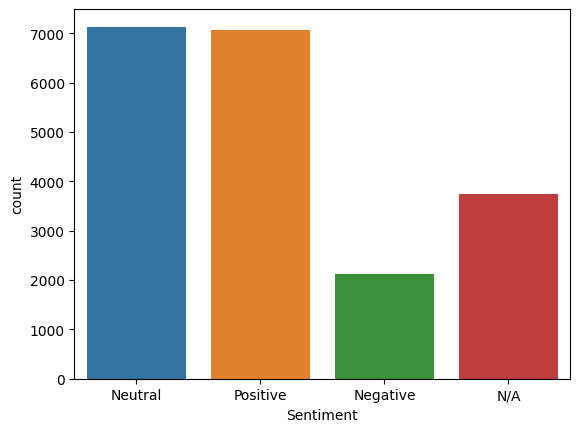

In [ ]:
import seaborn as sns
sns.countplot(x=sentiment_df_gender_classifier['Sentiment'], data=sentiment_df_gender_classifier)
# plt.ylim(0, 500)

<Axes: xlabel='Sentiment', ylabel='count'>

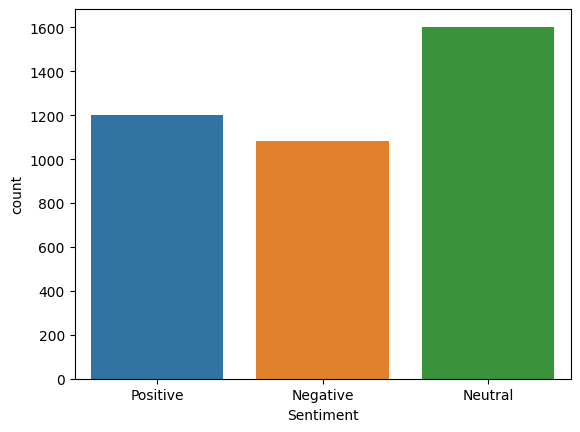

In [ ]:
import seaborn as sns
sns.countplot(x=Apple_Twitter_Sentiment_df['Sentiment'], data=sentiment_df_apple)
# plt.ylim(0, 500)

<Axes: xlabel='Sentiment', ylabel='count'>

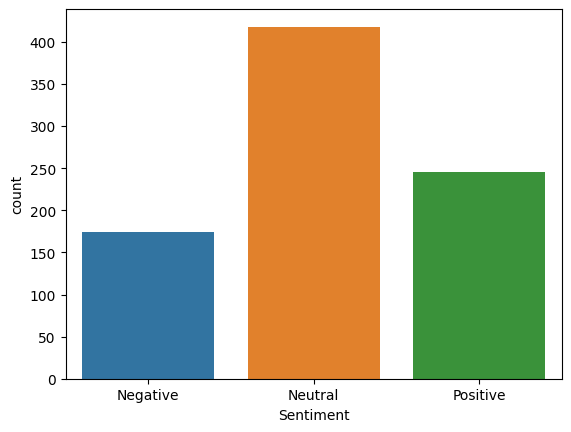

In [ ]:
import seaborn as sns
sns.countplot(x=Canada_Immigration_df['Sentiment'], data=sentiment_df_Canada_Immigration)
# plt.ylim(0, 500)

<Axes: xlabel='Sentiment', ylabel='count'>

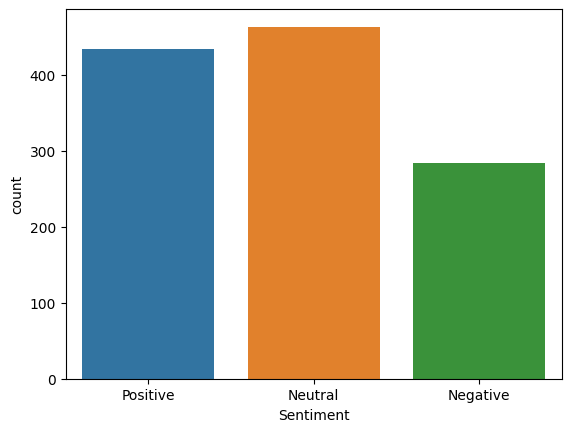

In [ ]:
import seaborn as sns
sns.countplot(x=tweets_Iphone_df['Sentiment'], data=sentiment_df_tweets_Iphone)
# plt.ylim(0, 500)

In [ ]:
# Selecting the text and Target column for our further analysis

data_gender_classifier = sentiment_df_gender_classifier[['description','Compound Score']]
data_Apple_Twitter = sentiment_df_apple[['text','Compound Score']]
data_Canada_Immigration_df = sentiment_df_Canada_Immigration[['text','Compound Score']]
data_tweets_Iphone_df = sentiment_df_tweets_Iphone[['text','Compound Score']]

In [ ]:
data_gender_classifier

,description,Compound Score
0,i sing my own rhythm.,0.0000
1,I'm the author of novels filled with family dr...,0.5574
2,louis whining and squealing and all,-0.2263
3,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",0.0000
4,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,0.9477
...,...,...
20045,(rp),0.0000
20046,"Whatever you like, it's not a problem at all. ...",0.5801
20047,#TeamBarcelona ..You look lost so you should f...,-0.3666
20048,Anti-statist; I homeschool my kids. Aspiring t...,0.0000


In [ ]:
# Separating positive and negative tweets
gender_classifier_data_pos = data_gender_classifier[data_gender_classifier['Compound Score'] < 1]
gender_classifier_data_neg = data_gender_classifier[data_gender_classifier['Compound Score'] > 0]

Apple_Twitter_data_pos = data_Apple_Twitter[data_Apple_Twitter['Compound Score'] < 1]
Apple_Twitter_data_neg = data_Apple_Twitter[data_Apple_Twitter['Compound Score'] > 0]

Canada_Immigration_data_pos = data_Canada_Immigration_df[data_Canada_Immigration_df['Compound Score'] < 1]
Canada_Immigration_data_neg = data_Canada_Immigration_df[data_Canada_Immigration_df['Compound Score'] > 0]

tweets_Iphone_data_pos = data_tweets_Iphone_df[data_tweets_Iphone_df['Compound Score'] < 1]
tweets_Iphone_data_neg = data_tweets_Iphone_df[data_tweets_Iphone_df['Compound Score'] > 0]

In [ ]:
gender_classifier_dataset = pd.concat([gender_classifier_data_pos, gender_classifier_data_neg])

Apple_Twitter_dataset = pd.concat([Apple_Twitter_data_pos, Apple_Twitter_data_neg])

Canada_Immigration_dataset = pd.concat([Canada_Immigration_data_pos, Canada_Immigration_data_neg])

tweets_Iphone_dataset = pd.concat([tweets_Iphone_data_pos, tweets_Iphone_data_neg])

In [ ]:
tweets_Iphone_dataset

,text,Compound Score
0,"I have to say, Apple has by far the best custo...",0.8268
1,iOS 7 is so fricking smooth & beautiful!! #Tha...,0.7207
2,LOVE U @APPLE,0.6369
3,"Thank you @apple, loving my new iPhone 5S!!!!!...",0.8209
4,.@apple has the best customer service. In and ...,0.6696
...,...,...
1129,stop making new iPhones and improve the darn c...,0.2481
1130,Nothing short of a disgrace @Apple @facebook @...,0.1098
1142,pictures on here won't load freak you @twitter...,0.3412
1154,I hate how my phone won't focus when I take a ...,0.0258


In [ ]:
# Making statement text in lowercase

gender_classifier_dataset['text'] = gender_classifier_dataset['description'].str.lower()
gender_classifier_dataset.drop(columns=['description'], inplace=True)
#gender_classifier_dataset['Compound Score'].tail()

Apple_Twitter_dataset['text'] = Apple_Twitter_dataset['text'].str.lower()
#Apple_Twitter_dataset['Compound Score'].tail()

Canada_Immigration_dataset['text'] = Canada_Immigration_dataset['text'].str.lower()
#Canada_Immigration_dataset['Compound Score'].tail()

tweets_Iphone_dataset['text'] = tweets_Iphone_dataset['text'].str.lower()
#tweets_Iphone_dataset['Compound Score'].tail()


In [ ]:
#gender_classifier_dataset.drop(columns=['description'], inplace=True)

In [ ]:
# Defining set containing all stopwords in English
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']



In [ ]:
# Cleaning and removing the above stop words list from the tweet text

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
gender_classifier_dataset['text'] = gender_classifier_dataset['text'].apply(lambda text: cleaning_stopwords(text))
Apple_Twitter_dataset['text'] = Apple_Twitter_dataset['text'].apply(lambda text: cleaning_stopwords(text))
Canada_Immigration_dataset['text'] = Canada_Immigration_dataset['text'].apply(lambda text: cleaning_stopwords(text))
tweets_Iphone_dataset['text'] = tweets_Iphone_dataset['text'].apply(lambda text: cleaning_stopwords(text))


In [ ]:
# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
gender_classifier_dataset['text']= gender_classifier_dataset['text'].apply(lambda x: cleaning_punctuations(x))
Apple_Twitter_dataset['text']= Apple_Twitter_dataset['text'].apply(lambda x: cleaning_punctuations(x))
Canada_Immigration_dataset['text']= Canada_Immigration_dataset['text'].apply(lambda x: cleaning_punctuations(x))
tweets_Iphone_dataset['text']= tweets_Iphone_dataset['text'].apply(lambda x: cleaning_punctuations(x))



In [ ]:
# Cleaning and removing repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
gender_classifier_dataset['text'] = gender_classifier_dataset['text'].apply(lambda x: cleaning_repeating_char(x))
Apple_Twitter_dataset['text'] = Apple_Twitter_dataset['text'].apply(lambda x: cleaning_repeating_char(x))
Canada_Immigration_dataset['text'] = Canada_Immigration_dataset['text'].apply(lambda x: cleaning_repeating_char(x))
tweets_Iphone_dataset['text'] = tweets_Iphone_dataset['text'].apply(lambda x: cleaning_repeating_char(x))


In [ ]:
# Cleaning and removing URLs
def cleaning_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
gender_classifier_dataset['text'] = gender_classifier_dataset['text'].apply(lambda x: cleaning_URLs(x))
Apple_Twitter_dataset['text'] = Apple_Twitter_dataset['text'].apply(lambda x: cleaning_URLs(x))
Canada_Immigration_dataset['text'] = Canada_Immigration_dataset['text'].apply(lambda x: cleaning_URLs(x))
tweets_Iphone_dataset['text'] = tweets_Iphone_dataset['text'].apply(lambda x: cleaning_URLs(x))


In [ ]:
# Cleaning and removing numeric numbers
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)
gender_classifier_dataset['text'] = gender_classifier_dataset['text'].apply(lambda x: cleaning_numbers(x))
Apple_Twitter_dataset['text'] = Apple_Twitter_dataset['text'].apply(lambda x: cleaning_numbers(x))
Canada_Immigration_dataset['text'] = Canada_Immigration_dataset['text'].apply(lambda x: cleaning_numbers(x))
tweets_Iphone_dataset['text'] = tweets_Iphone_dataset['text'].apply(lambda x: cleaning_numbers(x))


In [ ]:
text1 = gender_classifier_dataset['text'].values
text2 = Apple_Twitter_dataset['text'].values
text3 = Canada_Immigration_dataset['text'].values
text4 = tweets_Iphone_dataset['text'].values

wordcloud1 = WordCloud().generate(str(text1))
wordcloud2 = WordCloud().generate(str(text2))
wordcloud3 = WordCloud().generate(str(text3))
wordcloud4 = WordCloud().generate(str(text4))


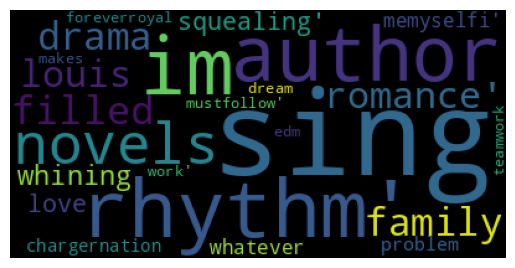

In [ ]:
#gender_classifier_dataset
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()


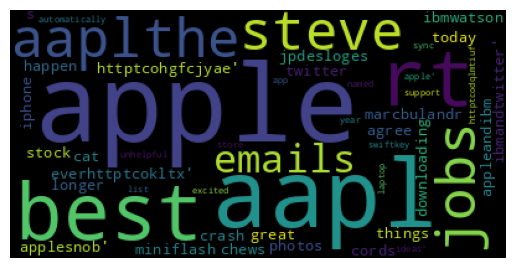

In [ ]:
#Apple_Twitter_dataset
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()


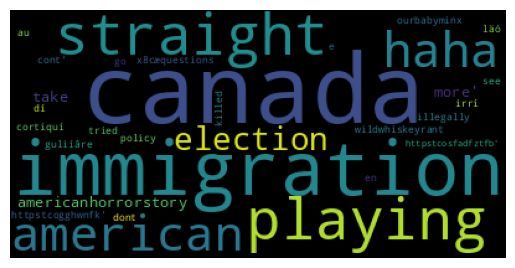

In [ ]:
#Canada_Immigration_dataset
plt.imshow(wordcloud3)
plt.axis("off")
plt.show()


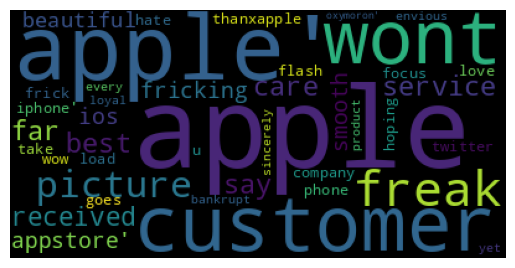

In [ ]:
#tweets_Iphone_dataset
plt.imshow(wordcloud4)
plt.axis("off")
plt.show()


In [ ]:
# Separating input feature and label
X_gender_classifier_dataset = sentiment_df_gender_classifier.description
Y_gender_classifier_dataset = sentiment_df_gender_classifier['Sentiment']

X_Apple_Twitter_dataset = sentiment_df_apple.text
Y_Apple_Twitter_dataset = sentiment_df_apple['Sentiment']

X_Canada_Immigration_dataset = sentiment_df_Canada_Immigration.text
Y_Canada_Immigration_dataset = sentiment_df_Canada_Immigration['Sentiment']

X_tweets_Iphone_dataset = sentiment_df_tweets_Iphone.text
Y_tweets_Iphone_dataset = sentiment_df_tweets_Iphone['Sentiment']

In [ ]:
# Splitting Our Data Into Train and Test Subsets
# Separating the 95% data for training data and 5% for testing data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_gender_classifier_dataset,Y_gender_classifier_dataset,test_size = 0.05, random_state =26105111)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_Apple_Twitter_dataset,Y_Apple_Twitter_dataset,test_size = 0.05, random_state =26105111)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_Canada_Immigration_dataset,Y_Canada_Immigration_dataset,test_size = 0.05, random_state =26105111)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_tweets_Iphone_dataset,Y_tweets_Iphone_dataset,test_size = 0.05, random_state =26105111)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Drop rows with missing values in the 'description' column
sentiment_df_gender_classifier = sentiment_df_gender_classifier.dropna(subset=['description'])
sentiment_df_apple = sentiment_df_apple.dropna(subset=['text'])
sentiment_df_Canada_Immigration = sentiment_df_Canada_Immigration.dropna(subset=['text'])
sentiment_df_tweets_Iphone = sentiment_df_tweets_Iphone.dropna(subset=['text'])

# Transforming the Dataset Using TF-IDF Vectorizer

# Vectorizer for sentiment_df_gender_classifier
vectoriser1 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_1 = vectoriser1.fit_transform(sentiment_df_gender_classifier['description'])
X_test_tfidf_1 = vectoriser1.transform(sentiment_df_gender_classifier['description'])

# Vectorizer for sentiment_df_apple
vectoriser2 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_2 = vectoriser2.fit_transform(sentiment_df_apple['text'])
X_test_tfidf_2 = vectoriser2.transform(sentiment_df_apple['text'])

# Vectorizer for sentiment_df_Canada_Immigration
vectoriser3 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_3 = vectoriser3.fit_transform(sentiment_df_Canada_Immigration['text'])
X_test_tfidf_3 = vectoriser3.transform(sentiment_df_Canada_Immigration['text'])

# Vectorizer for sentiment_df_tweets_Iphone
vectoriser4 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_4 = vectoriser4.fit_transform(sentiment_df_tweets_Iphone['text'])
X_test_tfidf_4 = vectoriser4.transform(sentiment_df_tweets_Iphone['text'])




In [ ]:
# Get the feature names for one of the vectorizers
feature_names = vectoriser1.get_feature_names_out()
print('No. of feature_words: ', len(feature_names))

No. of feature_words:  160708


In [ ]:
# Get the feature names for one of the vectorizers
feature_names = vectoriser2.get_feature_names_out()
print('No. of feature_words: ', len(feature_names))

No. of feature_words:  35086


In [ ]:
# Get the feature names for one of the vectorizers
feature_names = vectoriser3.get_feature_names_out()
print('No. of feature_words: ', len(feature_names))

No. of feature_words:  10449


In [ ]:
# Get the feature names for one of the vectorizers
feature_names = vectoriser4.get_feature_names_out()
print('No. of feature_words: ', len(feature_names))

No. of feature_words:  15081


In [ ]:
#1
#For gender_classifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming sentiment_df_gender_classifier is your DataFrame
# Drop rows with missing values in the 'description' column
sentiment_df_gender_classifier = sentiment_df_gender_classifier.dropna(subset=['description'])


# Separating input feature and label
X_gender_classifier_dataset = sentiment_df_gender_classifier.description
Y_gender_classifier_dataset = sentiment_df_gender_classifier['Sentiment']

# Splitting Our Data Into Train and Test Subsets
# Separating the 95% data for training data and 5% for testing data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_gender_classifier_dataset,Y_gender_classifier_dataset,test_size = 0.05, random_state =26105111)

# Transforming the Dataset Using TF-IDF Vectorizer
# Fit the TF-IDF Vectorizer

vectoriser_1 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_1 = vectoriser_1.fit_transform(X_train_1)
X_test_tfidf_1 = vectoriser_1.transform(X_test_1)

# Get the feature names
feature_names_1 = vectoriser_1.get_feature_names_out()
print('No. of feature_words: ', len(feature_names_1))

#1
#For gender_classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a logistic regression model
#logreg_model = LogisticRegression(random_state=26105111)
logreg_model_1 = LogisticRegression(random_state=26105111, max_iter=1000)


# Train the model on the training set
logreg_model_1.fit(X_train_tfidf_1, y_train_1)

# Predictions on the test set
y_pred_1 = logreg_model_1.predict(X_test_tfidf_1)

# Evaluate the model
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
conf_matrix_1 = confusion_matrix(y_test_1, y_pred_1)
classification_rep_1 = classification_report(y_test_1, y_pred_1)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy_1 * 100))
print("\nConfusion Matrix:\n", conf_matrix_1)
print("\nClassification Report:\n", classification_rep_1)



No. of feature_words:  154330
Accuracy: 72.55%

Confusion Matrix:
 [[ 18  29  50]
 [  5 267 101]
 [  6  33 307]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.62      0.19      0.29        97
     Neutral       0.81      0.72      0.76       373
    Positive       0.67      0.89      0.76       346

    accuracy                           0.73       816
   macro avg       0.70      0.60      0.60       816
weighted avg       0.73      0.73      0.71       816



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model_1 = RandomForestClassifier(random_state=26105111)

# Train the model on the training set
rf_model_1.fit(X_train_tfidf_1, y_train_1)

# Predictions on the test set
y_pred_rf_1 = rf_model_1.predict(X_test_tfidf_1)

# Evaluate the model
accuracy_rf_1 = accuracy_score(y_test_1, y_pred_rf_1)
conf_matrix_rf_1 = confusion_matrix(y_test_1, y_pred_rf_1)
classification_rep_rf_1 = classification_report(y_test_1, y_pred_rf_1)

# Print the results
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf_1 * 100))
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_rf_1)
print("\nRandom Forest Classification Report:\n", classification_rep_rf_1)


Random Forest Accuracy: 76.47%

Random Forest Confusion Matrix:
 [[ 14  48  35]
 [  2 342  29]
 [  1  77 268]]

Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.14      0.25        97
     Neutral       0.73      0.92      0.81       373
    Positive       0.81      0.77      0.79       346

    accuracy                           0.76       816
   macro avg       0.79      0.61      0.62       816
weighted avg       0.77      0.76      0.74       816



In [ ]:
#2
#For df_Apple

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming sentiment_df_gender_classifier is your DataFrame
# Drop rows with missing values in the 'description' column
sentiment_df_apple = sentiment_df_apple.dropna(subset=['text'])


# Separating input feature and label
X_Apple_Twitter_dataset = sentiment_df_apple.text
Y_Apple_Twitter_dataset = sentiment_df_apple['Sentiment']

# Splitting Our Data Into Train and Test Subsets
# Separating the 95% data for training data and 5% for testing data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_Apple_Twitter_dataset,Y_Apple_Twitter_dataset,test_size = 0.05, random_state =26105111)

# Transforming the Dataset Using TF-IDF Vectorizer
# Fit the TF-IDF Vectorizer

vectoriser_2 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_2 = vectoriser_2.fit_transform(X_train_2)
X_test_tfidf_2 = vectoriser_2.transform(X_test_2)

# Get the feature names
feature_names_2 = vectoriser_2.get_feature_names_out()
print('No. of feature_words: ', len(feature_names_2))

#2
#For df_tweets_Iphone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a logistic regression model
#logreg_model = LogisticRegression(random_state=26105111)
logreg_model_2 = LogisticRegression(random_state=26105111, max_iter=1000)


# Train the model on the training set
logreg_model_2.fit(X_train_tfidf_2, y_train_2)

# Predictions on the test set
y_pred_2 = logreg_model_2.predict(X_test_tfidf_2)

# Evaluate the model
accuracy_2 = accuracy_score(y_test_2, y_pred_2)
conf_matrix_2 = confusion_matrix(y_test_2, y_pred_2)
classification_rep_2 = classification_report(y_test_2, y_pred_2)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy_2 * 100))
print("\nConfusion Matrix:\n", conf_matrix_2)
print("\nClassification Report:\n", classification_rep_2)



No. of feature_words:  33873
Accuracy: 78.46%

Confusion Matrix:
 [[32  6  8]
 [ 9 77  9]
 [ 1  9 44]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.76      0.70      0.73        46
     Neutral       0.84      0.81      0.82        95
    Positive       0.72      0.81      0.77        54

    accuracy                           0.78       195
   macro avg       0.77      0.77      0.77       195
weighted avg       0.79      0.78      0.78       195



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model_2 = RandomForestClassifier(random_state=26105111)

# Train the model on the training set
rf_model_2.fit(X_train_tfidf_2, y_train_2)

# Predictions on the test set
y_pred_rf_2 = rf_model_2.predict(X_test_tfidf_2)

# Evaluate the model
accuracy_rf_2 = accuracy_score(y_test_2, y_pred_rf_2)
conf_matrix_rf_2 = confusion_matrix(y_test_2, y_pred_rf_2)
classification_rep_rf_2 = classification_report(y_test_2, y_pred_rf_2)

# Print the results
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf_2 * 100))
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_rf_2)
print("\nRandom Forest Classification Report:\n", classification_rep_rf_2)


Random Forest Accuracy: 78.46%

Random Forest Confusion Matrix:
 [[29 13  4]
 [ 4 88  3]
 [ 2 16 36]]

Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       0.83      0.63      0.72        46
     Neutral       0.75      0.93      0.83        95
    Positive       0.84      0.67      0.74        54

    accuracy                           0.78       195
   macro avg       0.81      0.74      0.76       195
weighted avg       0.79      0.78      0.78       195



In [ ]:
#3
#For df_Canada_Immigration

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming sentiment_df_gender_classifier is your DataFrame
# Drop rows with missing values in the 'description' column
sentiment_df_Canada_Immigration = sentiment_df_Canada_Immigration.dropna(subset=['text'])


# Separating input feature and label
X_Canada_Immigration_dataset = sentiment_df_Canada_Immigration.text
Y_Canada_Immigration_dataset = sentiment_df_Canada_Immigration['Sentiment']

# Splitting Our Data Into Train and Test Subsets
# Separating the 95% data for training data and 5% for testing data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_Canada_Immigration_dataset,Y_Canada_Immigration_dataset,test_size = 0.05, random_state =26105111)

# Transforming the Dataset Using TF-IDF Vectorizer
# Fit the TF-IDF Vectorizer

vectoriser_3 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_3 = vectoriser_3.fit_transform(X_train_3)
X_test_tfidf_3 = vectoriser_3.transform(X_test_3)

# Get the feature names
feature_names_3 = vectoriser_3.get_feature_names_out()
print('No. of feature_words: ', len(feature_names_3))

#3
#For Canada_Immigration
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a logistic regression model
#logreg_model = LogisticRegression(random_state=26105111)
logreg_model_3 = LogisticRegression(random_state=26105111, max_iter=1000)


# Train the model on the training set
logreg_model_3.fit(X_train_tfidf_3, y_train_3)

# Predictions on the test set
y_pred_3 = logreg_model_3.predict(X_test_tfidf_3)

# Evaluate the model
accuracy_3 = accuracy_score(y_test_3, y_pred_3)
conf_matrix_3 = confusion_matrix(y_test_3, y_pred_3)
classification_rep_3 = classification_report(y_test_3, y_pred_3)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy_3 * 100))
print("\nConfusion Matrix:\n", conf_matrix_3)
print("\nClassification Report:\n", classification_rep_3)



No. of feature_words:  10076
Accuracy: 69.05%

Confusion Matrix:
 [[ 5  3  2]
 [ 0 17  1]
 [ 0  7  7]]

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.50      0.67        10
     Neutral       0.63      0.94      0.76        18
    Positive       0.70      0.50      0.58        14

    accuracy                           0.69        42
   macro avg       0.78      0.65      0.67        42
weighted avg       0.74      0.69      0.68        42



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model_3 = RandomForestClassifier(random_state=26105111)

# Train the model on the training set
rf_model_3.fit(X_train_tfidf_3, y_train_3)

# Predictions on the test set
y_pred_rf_3 = rf_model_3.predict(X_test_tfidf_3)

# Evaluate the model
accuracy_rf_3 = accuracy_score(y_test_3, y_pred_rf_3)
conf_matrix_rf_3 = confusion_matrix(y_test_3, y_pred_rf_3)
classification_rep_rf_3 = classification_report(y_test_3, y_pred_rf_3)

# Print the results
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf_3 * 100))
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_rf_3)
print("\nRandom Forest Classification Report:\n", classification_rep_rf_3)


Random Forest Accuracy: 71.43%

Random Forest Confusion Matrix:
 [[ 6  4  0]
 [ 0 17  1]
 [ 0  7  7]]

Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.60      0.75        10
     Neutral       0.61      0.94      0.74        18
    Positive       0.88      0.50      0.64        14

    accuracy                           0.71        42
   macro avg       0.83      0.68      0.71        42
weighted avg       0.79      0.71      0.71        42



In [ ]:
#4
#For df_tweets_Iphone

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming sentiment_df_gender_classifier is your DataFrame
# Drop rows with missing values in the 'description' column
sentiment_df_tweets_Iphone = sentiment_df_tweets_Iphone.dropna(subset=['text'])


# Separating input feature and label
X_tweets_Iphone_dataset = sentiment_df_tweets_Iphone.text
Y_tweets_Iphone_dataset = sentiment_df_tweets_Iphone['Sentiment']

# Splitting Our Data Into Train and Test Subsets
# Separating the 95% data for training data and 5% for testing data
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_tweets_Iphone_dataset,Y_tweets_Iphone_dataset,test_size = 0.05, random_state =26105111)

# Transforming the Dataset Using TF-IDF Vectorizer
# Fit the TF-IDF Vectorizer

vectoriser_4 = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
X_train_tfidf_4 = vectoriser_4.fit_transform(X_train_4)
X_test_tfidf_4 = vectoriser_4.transform(X_test_4)

# Get the feature names
feature_names_4 = vectoriser_4.get_feature_names_out()
print('No. of feature_words: ', len(feature_names_4))


#4
#For df_tweets_Iphone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a logistic regression model
#logreg_model = LogisticRegression(random_state=26105111)
logreg_model_4 = LogisticRegression(random_state=26105111, max_iter=1000)


# Train the model on the training set
logreg_model_4.fit(X_train_tfidf_4, y_train_4)

# Predictions on the test set
y_pred_4 = logreg_model_4.predict(X_test_tfidf_4)

# Evaluate the model
accuracy_4 = accuracy_score(y_test_4, y_pred_4)
conf_matrix_4 = confusion_matrix(y_test_4, y_pred_4)
classification_rep_4 = classification_report(y_test_4, y_pred_4)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy_4 * 100))
print("\nConfusion Matrix:\n", conf_matrix_4)
print("\nClassification Report:\n", classification_rep_4)



No. of feature_words:  14466
Accuracy: 61.67%

Confusion Matrix:
 [[ 4  3  7]
 [ 0 14  8]
 [ 0  5 19]]

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.29      0.44        14
     Neutral       0.64      0.64      0.64        22
    Positive       0.56      0.79      0.66        24

    accuracy                           0.62        60
   macro avg       0.73      0.57      0.58        60
weighted avg       0.69      0.62      0.60        60



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
rf_model_4 = RandomForestClassifier(random_state=26105111)

# Train the model on the training set
rf_model_4.fit(X_train_tfidf_4, y_train_4)

# Predictions on the test set
y_pred_rf_4 = rf_model_4.predict(X_test_tfidf_4)

# Evaluate the model
accuracy_rf_4 = accuracy_score(y_test_4, y_pred_rf_4)
conf_matrix_rf_4 = confusion_matrix(y_test_4, y_pred_rf_4)
classification_rep_rf_4 = classification_report(y_test_4, y_pred_rf_4)

# Print the results
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf_4 * 100))
print("\nRandom Forest Confusion Matrix:\n", conf_matrix_rf_4)
print("\nRandom Forest Classification Report:\n", classification_rep_rf_4)


Random Forest Accuracy: 60.00%

Random Forest Confusion Matrix:
 [[ 3  9  2]
 [ 0 21  1]
 [ 0 12 12]]

Random Forest Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.21      0.35        14
     Neutral       0.50      0.95      0.66        22
    Positive       0.80      0.50      0.62        24

    accuracy                           0.60        60
   macro avg       0.77      0.56      0.54        60
weighted avg       0.74      0.60      0.57        60

